## Setup

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import cv2
import os
import PIL
import pathlib
import splitfolders

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

c:\programdata\miniconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\programdata\miniconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\programdata\miniconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
c:\programdata\miniconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Dataset Loading

In [4]:
base_ds = 'imgs'
base_ds = pathlib.Path(base_ds)

image_count = len(list(base_ds.glob('*/*.jpg')))
print(image_count)

18356


In [44]:
safe_driving = [fn for fn in os.listdir(f'{base_ds}/c0') if fn.endswith('.jpg')]
texting_right = [fn for fn in os.listdir(f'{base_ds}/c1') if fn.endswith('.jpg')]
calling_right = [fn for fn in os.listdir(f'{base_ds}/c2') if fn.endswith('.jpg')]
texting_left = [fn for fn in os.listdir(f'{base_ds}/c3') if fn.endswith('.jpg')]
calling_left = [fn for fn in os.listdir(f'{base_ds}/c4') if fn.endswith('.jpg')]
operating_radio = [fn for fn in os.listdir(f'{base_ds}/c5') if fn.endswith('.jpg')]
drinking = [fn for fn in os.listdir(f'{base_ds}/c6') if fn.endswith('.jpg')]
reaching_behind = [fn for fn in os.listdir(f'{base_ds}/c7') if fn.endswith('.jpg')]

img_classes = [safe_driving, texting_right, calling_right, texting_left, calling_left, operating_radio, drinking, reaching_behind]

In [6]:
classes = ['safe driving', 'texting-right', 'calling-right', 'texting-left', 'calling-left', 'operating radio', 'drinking', 'reaching behind']
classes

['safe driving',
 'texting-right',
 'calling-right',
 'texting-left',
 'calling-left',
 'operating radio',
 'drinking',
 'reaching behind']

Total images: 18384
Total number of classes: 8
Total safe driving images: 2489
Total texting-right images: 2267
Total calling-right images: 2317
Total texting-left images: 2346
Total calling-left images: 2326
Total operating radio images: 2312
Total drinking images: 2325
Total reaching behind images: 2002


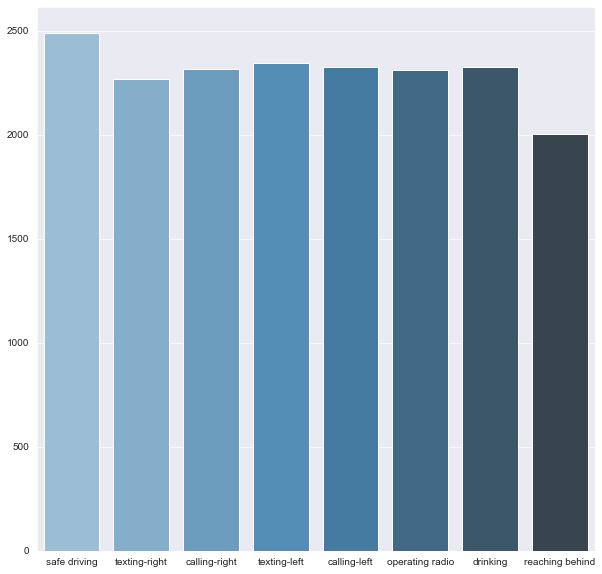

In [46]:
image_count = len(list(base_ds.glob('*/*.jpg')))
print(f'Total images: {image_count}')
print(f'Total number of classes: {len(classes)}')
count = 0
class_count = []
for x in classes:
  print(f'Total {x} images: {len(img_classes[count])}')
  class_count.append(len(img_classes[count]))
  count += 1

plt.figure(figsize=(10,10))
sns.set_style('darkgrid')
sns.barplot(x=classes, y=class_count, palette="Blues_d")
plt.show()

Image dimensions: (480, 640, 3)


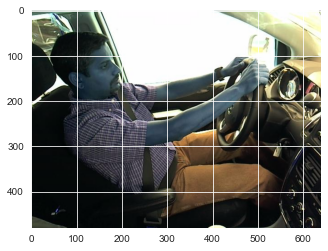

In [47]:
sample_img = cv2.imread('imgs/train/c0/img_34.jpg')
plt.imshow(sample_img)
print(f'Image dimensions: {sample_img.shape}')

## Dataset Splitting

In [8]:
splitfolders.ratio(base_ds, output='imgs_splitted', seed=123, ratio=(.8,.1,.1), group_prefix=None)

Copying files: 18356 files [00:22, 826.13 files/s]


In [79]:
batch_size = 32
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)

In [80]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range = 0.2, 
    zoom_range = 0.2)

val_datagen = ImageDataGenerator(
    rescale=1./255)

train_ds = train_datagen.flow_from_directory(
    'imgs_splitted/train',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    seed = 123,
    class_mode='categorical')

val_ds = val_datagen.flow_from_directory(
    'imgs_splitted/val',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    seed = 123,
    class_mode='categorical',
    shuffle=False)

test_ds = val_datagen.flow_from_directory(
    'imgs_splitted/test',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    seed = 123,
    class_mode='categorical',
    shuffle=False)


Found 14681 images belonging to 8 classes.
Found 1833 images belonging to 8 classes.
Found 1842 images belonging to 8 classes.


In [10]:
train_ds.class_indices = ['safe driving', 'texting-right', 'calling-right', 'texting-left', 'calling-left', 'operating radio', 'drinking', 'reaching behind']
val_ds.class_indices = ['safe driving', 'texting-right', 'calling-right', 'texting-left', 'calling-left', 'operating radio', 'drinking', 'reaching behind']
test_ds.class_indices = ['safe driving', 'texting-right', 'calling-right', 'texting-left', 'calling-left', 'operating radio', 'drinking', 'reaching behind']

In [2]:
def plot_train_history(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

## Model - Vanilla CNN

In [11]:
model_vanilla = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3), activation='relu', input_shape=input_shape),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(8, activation='softmax')
])

In [12]:
model_vanilla.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_vanilla.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 222, 222, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                        

In [18]:
models_dir = "new_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    

checkpointer = ModelCheckpoint(filepath='new_models/model_vanilla.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.0001)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [15]:
history1 = model_vanilla.fit(train_ds, epochs = 100, validation_data = val_ds, callbacks=callbacks)

Epoch 1/100
459/459 [==============================] - ETA: 0s - loss: 0.7021 - accuracy: 0.7619
Epoch 1: val_accuracy improved from -inf to 0.73704, saving model to saved_models\model_vanilla.hdf5
459/459 [==============================] - 131s 269ms/step - loss: 0.7021 - accuracy: 0.7619 - val_loss: 0.8283 - val_accuracy: 0.7370 - lr: 0.0010
Epoch 2/100
459/459 [==============================] - ETA: 0s - loss: 0.2069 - accuracy: 0.9328
Epoch 2: val_accuracy improved from 0.73704 to 0.98145, saving model to saved_models\model_vanilla.hdf5
459/459 [==============================] - 121s 263ms/step - loss: 0.2069 - accuracy: 0.9328 - val_loss: 0.0692 - val_accuracy: 0.9815 - lr: 0.0010
Epoch 3/100
459/459 [==============================] - ETA: 0s - loss: 0.1342 - accuracy: 0.9570
Epoch 3: val_accuracy did not improve from 0.98145
459/459 [==============================] - 121s 263ms/step - loss: 0.1342 - accuracy: 0.9570 - val_loss: 0.1102 - val_accuracy: 0.9629 - lr: 0.0010
Epoch 4/1

In [20]:
model_vanilla.load_weights('new_models/model_vanilla.hdf5')

In [21]:
score1 = model_vanilla.evaluate(val_ds, verbose=1)

58/58 [==============================] - 5s 84ms/step - loss: 0.0123 - accuracy: 0.9984


## Model - VGG16

In [24]:
vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
vgg16.trainable = False
inputs = tf.keras.Input(input_shape)
x = vgg16(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(8, activation='softmax')(x)
model_vgg16 = tf.keras.Model(inputs, x)

In [25]:
model_vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_vgg16.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_5 (Dense)             (None, 1024)              525312    
                                                                 
 dense_6 (Dense)             (None, 8)                 8200      
                                                                 
Total params: 15,248,200
Trainable params: 533,512
Non-trainable params: 14,714,688
_________________________________________

In [26]:
checkpointer = ModelCheckpoint(filepath='new_models/model_vgg16.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.0001)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [27]:
history2 = model_vgg16.fit(train_ds, epochs = 100, validation_data = val_ds, callbacks=callbacks)

Epoch 1/100
459/459 [==============================] - ETA: 0s - loss: 1.3633 - accuracy: 0.5395
Epoch 1: val_accuracy improved from -inf to 0.73977, saving model to new_models\model_vgg16.hdf5
459/459 [==============================] - 126s 270ms/step - loss: 1.3633 - accuracy: 0.5395 - val_loss: 0.7857 - val_accuracy: 0.7398 - lr: 0.0010
Epoch 2/100
459/459 [==============================] - ETA: 0s - loss: 0.6001 - accuracy: 0.8260
Epoch 2: val_accuracy improved from 0.73977 to 0.89034, saving model to new_models\model_vgg16.hdf5
459/459 [==============================] - 122s 265ms/step - loss: 0.6001 - accuracy: 0.8260 - val_loss: 0.3805 - val_accuracy: 0.8903 - lr: 0.0010
Epoch 3/100
459/459 [==============================] - ETA: 0s - loss: 0.3756 - accuracy: 0.8903
Epoch 3: val_accuracy did not improve from 0.89034
459/459 [==============================] - 124s 270ms/step - loss: 0.3756 - accuracy: 0.8903 - val_loss: 0.3494 - val_accuracy: 0.8854 - lr: 0.0010
Epoch 4/100
459/4

In [28]:
model_vgg16.load_weights('new_models/model_vgg16.hdf5')

In [29]:
vgg16.trainable = True
model_vgg16.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
history3 = model_vgg16.fit(train_ds, epochs = 40, validation_data = val_ds, callbacks=callbacks)

Epoch 1/40
459/459 [==============================] - ETA: 0s - loss: 0.1018 - accuracy: 0.9682
Epoch 1: val_accuracy improved from 0.94763 to 0.98691, saving model to new_models\model_vgg16.hdf5
459/459 [==============================] - 130s 277ms/step - loss: 0.1018 - accuracy: 0.9682 - val_loss: 0.0506 - val_accuracy: 0.9869 - lr: 1.0000e-05
Epoch 2/40
459/459 [==============================] - ETA: 0s - loss: 0.0326 - accuracy: 0.9909
Epoch 2: val_accuracy improved from 0.98691 to 0.98800, saving model to new_models\model_vgg16.hdf5
459/459 [==============================] - 124s 270ms/step - loss: 0.0326 - accuracy: 0.9909 - val_loss: 0.0423 - val_accuracy: 0.9880 - lr: 1.0000e-05
Epoch 3/40
459/459 [==============================] - ETA: 0s - loss: 0.0207 - accuracy: 0.9950
Epoch 3: val_accuracy did not improve from 0.98800
459/459 [==============================] - 123s 269ms/step - loss: 0.0207 - accuracy: 0.9950 - val_loss: 0.0472 - val_accuracy: 0.9825 - lr: 1.0000e-05
Epoch

In [33]:
model_vgg16.load_weights('new_models/model_vgg16.hdf5')

In [35]:
score2 = model_vgg16.evaluate(val_ds, verbose=1)
print(f'Model 2 VGG16 Loss: {score2[0]}, Accuracy: {score2[1]*100}')

58/58 [==============================] - 5s 88ms/step - loss: 0.0034 - accuracy: 0.9995
Model 2 VGG16 Loss: 0.0034471871331334114, Accuracy: 99.94544386863708


## Model - ResNet50

In [36]:
resnet = tf.keras.applications.resnet.ResNet50(
    include_top=False,
    weights='imagenet'
)
for layer in resnet.layers[:143]:
    layers.trainable=False
x = tf.keras.layers.GlobalAveragePooling2D()(resnet.output)
x = tf.keras.layers.Dropout(rate=0.5)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(8, activation='softmax')(x)
model_resnet50 = tf.keras.Model(resnet.input, x)
model_resnet50.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [37]:
model_resnet50.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_resnet50.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_5[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                         

                                                                                                  
 conv2_block2_add (Add)         (None, None, None,   0           ['conv2_block1_out[0][0]',       
                                256)                              'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_block2_out (Activation)  (None, None, None,   0           ['conv2_block2_add[0][0]']       
                                256)                                                              
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, None, None,   16448       ['conv2_block2_out[0][0]']       
                                64)                                                               
                                                                                                  
 conv2_blo

                                128)                                                              
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, None, None,   512        ['conv3_block2_2_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, None, None,   0          ['conv3_block2_2_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, None, None,   66048       ['conv3_block2_2_relu[0][0]']    
                                512)                                                              
          

 conv4_block1_1_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_1_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, None, None,   0          ['conv4_block1_1_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block1_2_conv (Conv2D)   (None, None, None,   590080      ['conv4_block1_1_relu[0][0]']    
                                256)                                                              
                                                                                                  
 conv4_block1_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_2_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block3_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block3_3_conv[0][0]']    
 ization)                       1024)                                                             
                                                                                                  
 conv4_block3_add (Add)         (None, None, None,   0           ['conv4_block2_out[0][0]',       
                                1024)                             'conv4_block3_3_bn[0][0]']      
                                                                                                  
 conv4_block3_out (Activation)  (None, None, None,   0           ['conv4_block3_add[0][0]']       
                                1024)                                                             
                                                                                                  
 conv4_blo

 ization)                       256)                                                              
                                                                                                  
 conv4_block6_2_relu (Activatio  (None, None, None,   0          ['conv4_block6_2_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block6_3_conv (Conv2D)   (None, None, None,   263168      ['conv4_block6_2_relu[0][0]']    
                                1024)                                                             
                                                                                                  
 conv4_block6_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block6_3_conv[0][0]']    
 ization)                       1024)                                                             
          

 conv5_block3_1_conv (Conv2D)   (None, None, None,   1049088     ['conv5_block2_out[0][0]']       
                                512)                                                              
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, None, None,   2048       ['conv5_block3_1_conv[0][0]']    
 ization)                       512)                                                              
                                                                                                  
 conv5_block3_1_relu (Activatio  (None, None, None,   0          ['conv5_block3_1_bn[0][0]']      
 n)                             512)                                                              
                                                                                                  
 conv5_block3_2_conv (Conv2D)   (None, None, None,   2359808     ['conv5_block3_1_relu[0][0]']    
          

In [38]:
checkpointer = ModelCheckpoint(filepath='new_models/model_resnet50.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.0001)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [39]:
history4 = model_resnet50.fit(train_ds, epochs = 100, validation_data = val_ds, callbacks=callbacks)

Epoch 1/100
459/459 [==============================] - ETA: 0s - loss: 0.3345 - accuracy: 0.8978
Epoch 1: val_accuracy improved from -inf to 0.13475, saving model to new_models\model_resnet50.hdf5
459/459 [==============================] - 126s 265ms/step - loss: 0.3345 - accuracy: 0.8978 - val_loss: 2.7772 - val_accuracy: 0.1348 - lr: 0.0010
Epoch 2/100
459/459 [==============================] - ETA: 0s - loss: 0.0843 - accuracy: 0.9774
Epoch 2: val_accuracy improved from 0.13475 to 0.97272, saving model to new_models\model_resnet50.hdf5
459/459 [==============================] - 121s 263ms/step - loss: 0.0843 - accuracy: 0.9774 - val_loss: 0.1060 - val_accuracy: 0.9727 - lr: 0.0010
Epoch 3/100
459/459 [==============================] - ETA: 0s - loss: 0.0550 - accuracy: 0.9868
Epoch 3: val_accuracy did not improve from 0.97272
459/459 [==============================] - 125s 271ms/step - loss: 0.0550 - accuracy: 0.9868 - val_loss: 0.1427 - val_accuracy: 0.9634 - lr: 0.0010
Epoch 4/100

In [40]:
model_resnet50.load_weights('new_models/model_resnet50.hdf5')

In [41]:
resnet.trainable = True
model_resnet50.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])

In [42]:
history5 = model_resnet50.fit(train_ds, epochs = 100, validation_data = val_ds, callbacks=callbacks)

Epoch 1/100
459/459 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 0.9995
Epoch 1: val_accuracy did not improve from 0.99891
459/459 [==============================] - 123s 260ms/step - loss: 0.0017 - accuracy: 0.9995 - val_loss: 0.0106 - val_accuracy: 0.9978 - lr: 1.0000e-05
Epoch 2/100
459/459 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 0.9997
Epoch 2: val_accuracy did not improve from 0.99891
459/459 [==============================] - 119s 260ms/step - loss: 0.0019 - accuracy: 0.9997 - val_loss: 0.0100 - val_accuracy: 0.9978 - lr: 1.0000e-05
Epoch 3/100
459/459 [==============================] - ETA: 0s - loss: 7.3159e-04 - accuracy: 0.9998
Epoch 3: val_accuracy did not improve from 0.99891
459/459 [==============================] - 119s 260ms/step - loss: 7.3159e-04 - accuracy: 0.9998 - val_loss: 0.0108 - val_accuracy: 0.9978 - lr: 1.0000e-05
Epoch 4/100
459/459 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 0.

In [43]:
model_resnet50.load_weights('new_models/model_resnet50.hdf5')

In [44]:
score3 = model_resnet50.evaluate(val_ds, verbose=1)
print(f'ResNet50 Loss: {score3[0]}, Accuracy: {score3[1]*100}')

58/58 [==============================] - 5s 86ms/step - loss: 0.0098 - accuracy: 0.9989
ResNet50 Loss: 0.009784238412976265, Accuracy: 99.89088773727417


## Efficientnet

In [49]:
train_datagen = ImageDataGenerator()

val_datagen = ImageDataGenerator()

train_ds = train_datagen.flow_from_directory(
    'imgs_splitted/train',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    seed = 123,
    class_mode='categorical')

val_ds = val_datagen.flow_from_directory(
    'imgs_splitted/val',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    seed = 123,
    class_mode='categorical',
    shuffle=False)

test_ds = val_datagen.flow_from_directory(
    'imgs_splitted/test',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    seed = 123,
    class_mode='categorical',
    shuffle=False)


Found 14681 images belonging to 8 classes.
Found 1833 images belonging to 8 classes.
Found 1842 images belonging to 8 classes.


In [50]:
inputs = tf.keras.Input(input_shape)
efficientnet = tf.keras.applications.efficientnet.EfficientNetB3(
    include_top=False,
    weights='imagenet', input_tensor=inputs )
efficientnet.trainable = False
x = efficientnet(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(8, activation='softmax')(x)
model_efficientnet = tf.keras.Model(inputs, x)

In [51]:
model_efficientnet.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-2), loss='categorical_crossentropy', metrics=['accuracy'])
model_efficientnet.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb3 (Functional)  (None, 7, 7, 1536)       10783535  
                                                                 
 global_average_pooling2d_4   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_8 (Batc  (None, 1536)             6144      
 hNormalization)                                                 
                                                                 
 dropout_7 (Dropout)         (None, 1536)              0         
                                                                 
 dense_10 (Dense)            (None, 8)                 1229

In [52]:
checkpointer = ModelCheckpoint(filepath='new_models/model_efficientnet.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
callbacks=[early_stopping, checkpointer]

In [53]:
history6 = model_efficientnet.fit(train_ds, epochs = 20, validation_data = val_ds, callbacks=callbacks)

Epoch 1/20
459/459 [==============================] - ETA: 0s - loss: 0.4626 - accuracy: 0.8997
Epoch 1: val_accuracy improved from -inf to 0.95799, saving model to new_models\model_efficientnet.hdf5
459/459 [==============================] - 52s 104ms/step - loss: 0.4626 - accuracy: 0.8997 - val_loss: 0.1877 - val_accuracy: 0.9580
Epoch 2/20
459/459 [==============================] - ETA: 0s - loss: 0.3012 - accuracy: 0.9473
Epoch 2: val_accuracy improved from 0.95799 to 0.97600, saving model to new_models\model_efficientnet.hdf5
459/459 [==============================] - 47s 101ms/step - loss: 0.3012 - accuracy: 0.9473 - val_loss: 0.1730 - val_accuracy: 0.9760
Epoch 3/20
459/459 [==============================] - ETA: 0s - loss: 0.2927 - accuracy: 0.9544
Epoch 3: val_accuracy did not improve from 0.97600
459/459 [==============================] - 46s 101ms/step - loss: 0.2927 - accuracy: 0.9544 - val_loss: 0.2371 - val_accuracy: 0.9684
Epoch 4/20
459/459 [============================

In [55]:
model_efficientnet.load_weights('new_models/model_efficientnet.hdf5')

In [57]:
for layer in efficientnet.layers[-20:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

model_efficientnet.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])

In [58]:
history7 = model_efficientnet.fit(train_ds, epochs = 500, validation_data = val_ds, callbacks=callbacks)

Epoch 1/500
459/459 [==============================] - ETA: 0s - loss: 0.2302 - accuracy: 0.9718
Epoch 1: val_accuracy improved from 0.98472 to 0.98527, saving model to new_models\model_efficientnet.hdf5
459/459 [==============================] - 53s 106ms/step - loss: 0.2302 - accuracy: 0.9718 - val_loss: 0.1822 - val_accuracy: 0.9853
Epoch 2/500
459/459 [==============================] - ETA: 0s - loss: 0.2204 - accuracy: 0.9735
Epoch 2: val_accuracy did not improve from 0.98527
459/459 [==============================] - 48s 105ms/step - loss: 0.2204 - accuracy: 0.9735 - val_loss: 0.1795 - val_accuracy: 0.9853
Epoch 3/500
459/459 [==============================] - ETA: 0s - loss: 0.2219 - accuracy: 0.9740
Epoch 3: val_accuracy improved from 0.98527 to 0.98636, saving model to new_models\model_efficientnet.hdf5
459/459 [==============================] - 48s 105ms/step - loss: 0.2219 - accuracy: 0.9740 - val_loss: 0.1737 - val_accuracy: 0.9864
Epoch 4/500
459/459 [=====================

In [59]:
score4 = model_efficientnet.evaluate(val_ds, verbose=1)
print(f'EfficientNet Loss: {score4[0]}, Accuracy: {score4[1]*100}')

58/58 [==============================] - 6s 94ms/step - loss: 0.1527 - accuracy: 0.9907
EfficientNet Loss: 0.15270566940307617, Accuracy: 99.0725576877594


## InceptionV3

In [82]:
inception = tf.keras.applications.inception_v3.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape
)
inception.trainable = False
inputs = tf.keras.Input(input_shape)
x = inception(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(8, activation='softmax')(x)
model_inceptionv3 = tf.keras.Model(inputs, x)

In [83]:
model_inceptionv3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_inceptionv3.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_7   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_15 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_16 (Dense)            (None, 8)                 8200      
                                                                 
Total params: 23,909,160
Trainable params: 2,106,376
Non-trainable params: 21,802,784
_______________________________________

In [84]:
checkpointer = ModelCheckpoint(filepath='new_models/model_inceptionv3.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.0001)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [85]:
history8 = model_inceptionv3.fit(train_ds, epochs = 100, validation_data = val_ds, callbacks=callbacks)

Epoch 1/100
459/459 [==============================] - ETA: 0s - loss: 0.9207 - accuracy: 0.7074
Epoch 1: val_accuracy improved from -inf to 0.87343, saving model to new_models\model_inceptionv3.hdf5
459/459 [==============================] - 123s 264ms/step - loss: 0.9207 - accuracy: 0.7074 - val_loss: 0.3974 - val_accuracy: 0.8734 - lr: 0.0010
Epoch 2/100
459/459 [==============================] - ETA: 0s - loss: 0.4011 - accuracy: 0.8669
Epoch 2: val_accuracy improved from 0.87343 to 0.92362, saving model to new_models\model_inceptionv3.hdf5
459/459 [==============================] - 124s 271ms/step - loss: 0.4011 - accuracy: 0.8669 - val_loss: 0.2460 - val_accuracy: 0.9236 - lr: 0.0010
Epoch 3/100
459/459 [==============================] - ETA: 0s - loss: 0.3099 - accuracy: 0.8930
Epoch 3: val_accuracy improved from 0.92362 to 0.93235, saving model to new_models\model_inceptionv3.hdf5
459/459 [==============================] - 124s 270ms/step - loss: 0.3099 - accuracy: 0.8930 - val

In [86]:
model_inceptionv3.load_weights('new_models/model_inceptionv3.hdf5')

In [87]:
inception.trainable=True

model_inceptionv3.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])

model_inceptionv3.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_7   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_15 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_16 (Dense)            (None, 8)                 8200      
                                                                 
Total params: 23,909,160
Trainable params: 23,874,728
Non-trainable params: 34,432
__________________________________________

In [88]:
history9 = model_inceptionv3.fit(train_ds, epochs = 100, validation_data = val_ds, callbacks=callbacks)

Epoch 1/100
459/459 [==============================] - ETA: 0s - loss: 0.0620 - accuracy: 0.9796
Epoch 1: val_accuracy did not improve from 0.99018
459/459 [==============================] - 125s 263ms/step - loss: 0.0620 - accuracy: 0.9796 - val_loss: 0.0761 - val_accuracy: 0.9755 - lr: 1.0000e-05
Epoch 2/100
459/459 [==============================] - ETA: 0s - loss: 0.0313 - accuracy: 0.9907
Epoch 2: val_accuracy improved from 0.99018 to 0.99345, saving model to new_models\model_inceptionv3.hdf5
459/459 [==============================] - 120s 261ms/step - loss: 0.0313 - accuracy: 0.9907 - val_loss: 0.0179 - val_accuracy: 0.9935 - lr: 1.0000e-05
Epoch 3/100
459/459 [==============================] - ETA: 0s - loss: 0.0194 - accuracy: 0.9945
Epoch 3: val_accuracy did not improve from 0.99345
459/459 [==============================] - 120s 262ms/step - loss: 0.0194 - accuracy: 0.9945 - val_loss: 0.0362 - val_accuracy: 0.9902 - lr: 1.0000e-05
Epoch 4/100
459/459 [========================

In [89]:
model_inceptionv3.load_weights('new_models/model_inceptionv3.hdf5')

In [90]:
score5 = model_inceptionv3.evaluate(val_ds, verbose=1)
print(f'InceptionV3 Loss: {score5[0]}, Accuracy: {score5[1]*100}')

58/58 [==============================] - 5s 89ms/step - loss: 0.0202 - accuracy: 0.9956
InceptionV3 Loss: 0.02015676163136959, Accuracy: 99.56355690956116


In [91]:
print(f'Classic CNN Loss: {score1[0]}, Accuracy: {score1[1]*100}')
print(f'VGG16 Loss: {score2[0]}, Accuracy: {score2[1]*100}')
print(f'ResNet50 Loss: {score3[0]}, Accuracy: {score3[1]*100}')
print(f'EfficientNetB3 Loss: {score4[0]}, Accuracy: {score4[1]*100}')
print(f'InceptionV3 Loss: {score5[0]}, Accuracy: {score5[1]*100}')

Classic CNN Loss: 0.012284220196306705, Accuracy: 99.83633160591125
VGG16 Loss: 0.0034471871331334114, Accuracy: 99.94544386863708
ResNet50 Loss: 0.009784238412976265, Accuracy: 99.89088773727417
EfficientNetB3 Loss: 0.15270566940307617, Accuracy: 99.0725576877594
InceptionV3 Loss: 0.02015676163136959, Accuracy: 99.56355690956116


## Evaluation

In [92]:
score6 = model_vanilla.evaluate(test_ds, verbose=1)
score7 = model_vgg16.evaluate(test_ds, verbose=1)
score8 = model_resnet50.evaluate(test_ds, verbose=1)
score9 = model_inceptionv3.evaluate(test_ds, verbose=1)

print(f'Classic CNN Loss: {score6[0]}, Accuracy: {score6[1]*100}')
print(f'VGG16 Loss: {score7[0]}, Accuracy: {score7[1]*100}')
print(f'ResNet50 Loss: {score8[0]}, Accuracy: {score8[1]*100}')
print(f'InceptionV3 Loss: {score9[0]}, Accuracy: {score9[1]*100}')

58/58 [==============================] - 5s 89ms/step - loss: 0.0390 - accuracy: 0.9924
Classic CNN Loss: 0.023717818781733513, Accuracy: 99.51140284538269
VGG16 Loss: 0.016543041914701462, Accuracy: 99.78284239768982
ResNet50 Loss: 0.02534191682934761, Accuracy: 99.56569075584412
InceptionV3 Loss: 0.03903038427233696, Accuracy: 99.23995733261108


In [93]:
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model_resnet50.predict(test_ds)

In [98]:
test_ds.class_indices = ['safe driving', 'texting-right', 'calling-right', 'texting-left', 'calling-left', 'operating radio', 'drinking', 'reaching behind']

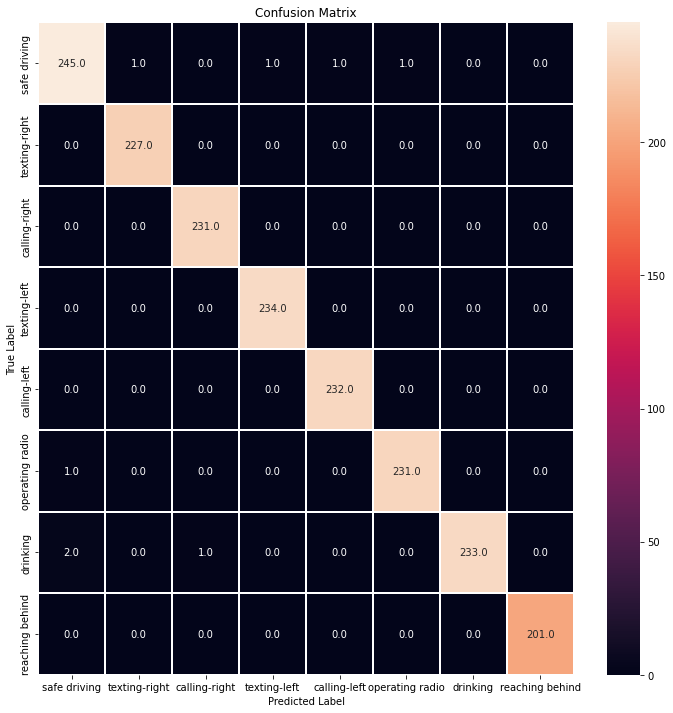

In [99]:
y_pred = np.argmax(Y_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(classes)
plt.title("Confusion Matrix")
plt.show()

In [102]:
report1 = classification_report(test_ds.classes, y_pred, target_names=classes, output_dict=True)
df1 = pd.DataFrame(report1).transpose()
df1

,precision,recall,f1-score,support
safe driving,0.983936,0.987903,0.985915,248.000000
texting-right,1.000000,0.995614,0.997802,228.000000
calling-right,1.000000,0.995690,0.997840,232.000000
texting-left,1.000000,0.995745,0.997868,235.000000
calling-left,1.000000,0.995708,0.997849,233.000000
operating radio,0.995690,0.995690,0.995690,232.000000
drinking,0.987288,1.000000,0.993603,233.000000
reaching behind,1.000000,1.000000,1.000000,201.000000
accuracy,0.995657,0.995657,0.995657,0.995657
macro avg,0.995864,0.995794,0.995821,1842.000000


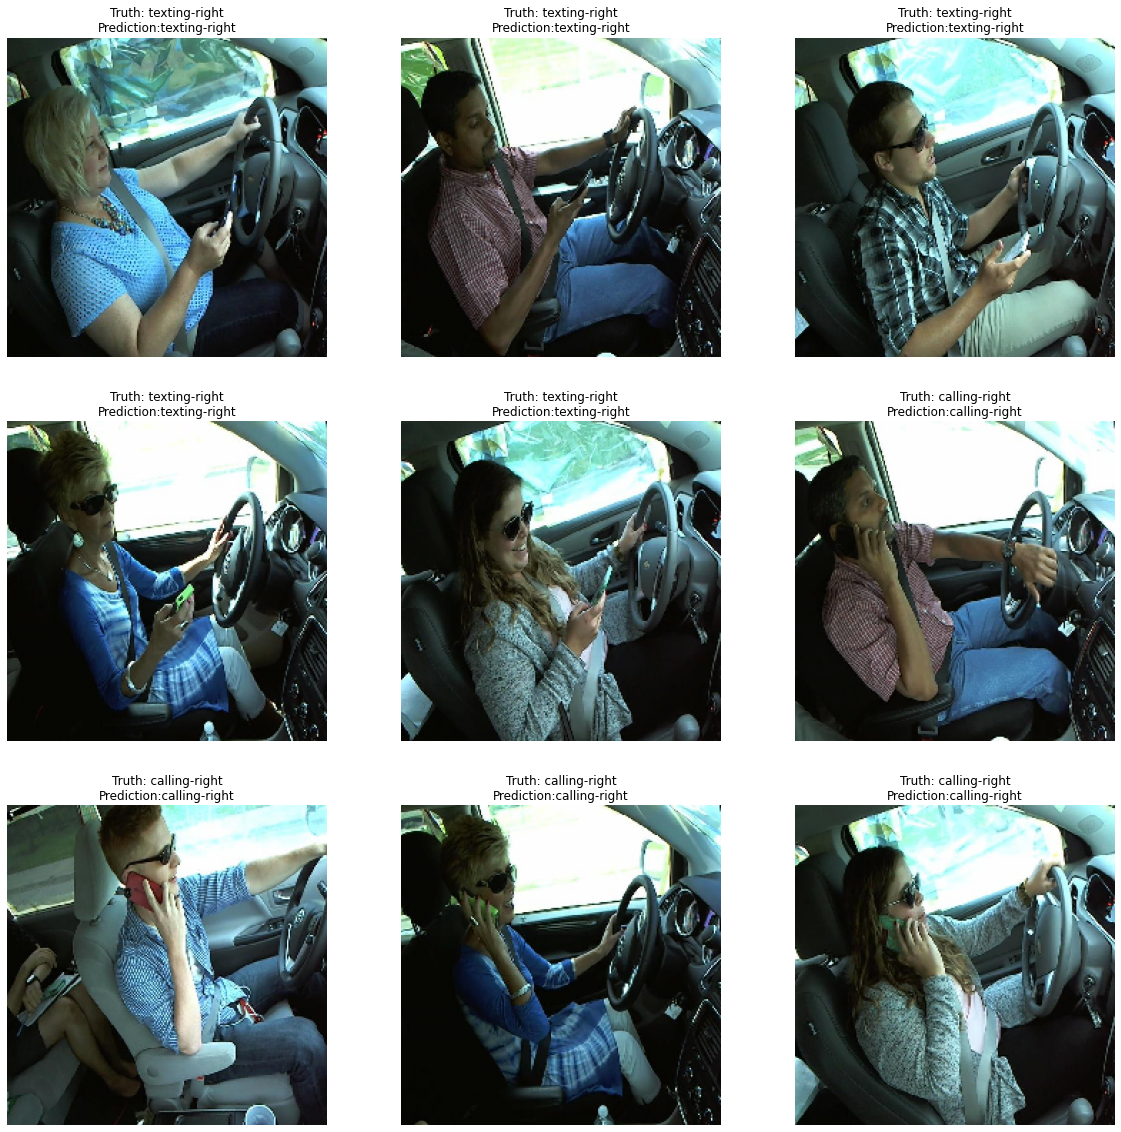

In [101]:
plt.figure(figsize=(20, 20))
for i in range(9):
    x, label= test_ds.next()
    plt.subplot(3, 3, i+1)
    plt.imshow(x[i])
    result = np.where(label[i]==1)
    predict = model_resnet50(tf.expand_dims(x[i], 0))
    score = tf.nn.softmax(predict[0])
    score_label = classes[np.argmax(score)]
    plt.title(f'Truth: {classes[result[0][0]]}\nPrediction:{score_label}')
    plt.axis(False)